In [1]:
from logisticRegression import LogisticRegression, Optimizer
from scipy.io.arff import loadarff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle

C:\Users\prusak.patryk\AppData\Local\Temp\ipykernel_29420\3845328473.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Helper functions

In [2]:
def addInteractions(X):
    newX=X
    for i in range(X.shape[1]):
        for j in range(i+1,X.shape[1]):
            newX=np.c_[newX,np.multiply(X[:,i],X[:,j])]
    return newX

In [3]:
def getMeanAccuracyPerSplit(accuracies):
    return accuracies.groupby(['split','classifier'])['accuracy'].mean().reset_index(name='accuracy')
def getMeanAccuracyPerDataset(accuracies):
    return accuracies.groupby(['dataset','classifier'])['accuracy'].mean().reset_index(name='accuracy')


In [11]:
def performExperiment(X,y,logisticparams, withInteractions,dataset):
    costs=[]
    accuracies=[]
    splits = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    # splits = [0.5]
    seeds = [42,123,0,321,9]
    # seeds = [42]
    classifiersNames = ['Linear Discriminant Analysis','Quadratic Discriminant Analysis', 'Decision Tree Classifier', 'Random Forest Classifier']
    classifiers = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),DecisionTreeClassifier(random_state=42),RandomForestClassifier(random_state=42)]
    for split in splits:
        for seed in seeds:
            np.random.seed(seed)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=seed)
            print("\nExperiment: split: "+str(split)+" seed: "+str(seed))
            for logisticparam in logisticparams:
                logisticRegressor = LogisticRegression(learningRate=logisticparam['learningRate'],noOfIterations=500, optimizer=logisticparam['optimizer'])
                cost = logisticRegressor.fit(X_train.astype(float),y_train.astype(float))
                y_pred=logisticRegressor.predict(X_test)
                costs.append([cost,logisticparam['optimizer'],seed,split,False,dataset])
                accuracies.append([balanced_accuracy_score(y_test, y_pred),logisticparam['optimizer'],seed,split,False,dataset])
            for i,classifier in enumerate(classifiers):
                history = classifier.fit(X_train.astype(float),y_train.astype(float))
                y_pred=classifier.predict(X_test)
                
                # costs.append([history, classifiersNames[i],seed,split,False,dataset])
                accuracies.append([balanced_accuracy_score(y_test, y_pred),classifiersNames[i],seed,split,False,dataset])
            if withInteractions==True:
                X_train=addInteractions(X_train)
                X_test = addInteractions(X_test)
                for logisticparam in logisticparams:
                    logisticRegressor = LogisticRegression(learningRate=logisticparam['learningRate'],noOfIterations=500, optimizer=logisticparam['optimizer'])
                    cost = logisticRegressor.fit(X_train.astype(float),y_train.astype(float))
                    y_pred=logisticRegressor.predict(X_test)
                    
                    costs.append([cost,logisticparam['optimizer'],seed,split,True,dataset])
                    accuracies.append([1-np.sum(np.abs(y_pred-y_test))/len(y_test),logisticparam['optimizer'],seed,split,True,dataset])
                
    return costs, accuracies
    

In [12]:
def mapOptimizerToString(datapoint):
    match datapoint['classifier']:
        case Optimizer.Adam:
            if datapoint['interactions'] == True:
                datapoint['classifier']= 'Adam Interactions'
            else:
                datapoint['classifier']= 'Adam'
        case Optimizer.SGD:
            if datapoint['interactions'] == True:
                datapoint['classifier']= 'SGD Interactions'
            else:
                datapoint['classifier']= 'SGD'
        case Optimizer.IWLS:
            if datapoint['interactions'] == True:
                datapoint['classifier']= 'IWLS Interactions'
            else:
                datapoint['classifier']= 'IWLS'
    return datapoint

## Load datasets

In [13]:
datasets=['blood-transfusion','iris']
Xs=[]
ys=[]

# Loading the dataset
raw_data = loadarff("./Datasets/blood-transfusion-service-center.arff")
df_data = pd.DataFrame(raw_data[0])
df_no_class=df_data.drop('Class',axis=1)
corr = df_no_class.corr()
mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
df_blood_no_class = df_no_class.loc[:, mask]
X = df_blood_no_class.to_numpy()
y = df_data['Class'].astype(int).to_numpy()
y[y==1]=0
y[y==2]=1
Xs.append(X)
ys.append(y)
# Loading dataset
raw_iris_data = loadarff("./Datasets/iris.arff")
df_iris_data = pd.DataFrame(raw_iris_data[0])

# Separating other features from target
df_iris_no_class = df_iris_data.drop('binaryClass', axis=1)

# Removing highly correlated features
corr = df_iris_no_class.corr()

mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
df_iris_no_class = df_iris_no_class.loc[:, mask]

# Creating X and Y
X_iris = df_iris_no_class.to_numpy()
y_iris = df_iris_data['binaryClass'].to_numpy()


y_iris[y_iris==b'P']=1
y_iris[y_iris==b'N']=0

y=y_iris.astype(int)
X=X_iris
Xs.append(X)
ys.append(y)


## Perform experiments

In [14]:
costs=[]
accuracies=[]

for i,X in enumerate(Xs):
    cost,accuracy = performExperiment(X,ys[i],[{'learningRate':0.001, 'optimizer':Optimizer.IWLS},{'learningRate':0.001, 'optimizer':Optimizer.Adam},{'learningRate':0.000001, 'optimizer':Optimizer.SGD}],True,dataset=datasets[i])
    costs.append(cost)
    accuracies.append(accuracy)
pickle.dump(costs, open('costs', 'wb'))
pickle.dump(accuracies, open('accuracies', 'wb'))


Experiment: split: 0.1 seed: 42
IWLS Converged after 5 iterations
Adam Converged after 313 iterations
SGD Converged after 226 iterations
IWLS Converged after 6 iterations
Adam Converged after 299 iterations
SGD Converged after 32 iterations

Experiment: split: 0.1 seed: 123
IWLS Converged after 6 iterations
Adam Converged after 333 iterations
SGD Converged after 176 iterations
IWLS Converged after 6 iterations
Adam Converged after 12 iterations
SGD Converged after 22 iterations

Experiment: split: 0.1 seed: 0
IWLS Converged after 6 iterations
Adam Converged after 323 iterations
SGD Converged after 254 iterations
IWLS Converged after 6 iterations
Adam Converged after 306 iterations
SGD Converged after 18 iterations

Experiment: split: 0.1 seed: 321
IWLS Converged after 5 iterations
Adam Converged after 315 iterations
SGD Converged after 292 iterations
IWLS Converged after 6 iterations
Adam Converged after 36 iterations
SGD Converged after 34 iterations

Experiment: split: 0.1 seed: 9
I

c:\Users\prusak.patryk\Projects\Uni\advml-proj-1\logisticRegression.py:138: RuntimeWarning: overflow encountered in exp
  yHat=1.0/(1.0+np.exp(-a))
c:\Users\prusak.patryk\Projects\Uni\advml-proj-1\logisticRegression.py:29: RuntimeWarning: overflow encountered in exp
  predicted  = 1/(1+np.exp(-(np.dot(X,self.w).astype(float) +self.bias)).astype(float))


IWLS Converged after 14 iterations
Adam Converged after 368 iterations
SGD Converged after 28 iterations

Experiment: split: 0.9 seed: 42
IWLS Converged after 14 iterations
Adam Converged after 498 iterations
SGD Converged after 1 iterations
IWLS Converged after 14 iterations
Adam Converged after 172 iterations
SGD Converged after 15 iterations

Experiment: split: 0.9 seed: 123
IWLS Converged after 13 iterations
Adam Converged after 401 iterations
SGD Converged after 1 iterations
IWLS Converged after 13 iterations
Adam Converged after 187 iterations
SGD Converged after 13 iterations

Experiment: split: 0.9 seed: 0
IWLS Converged after 14 iterations
Adam Converged after 135 iterations
SGD Converged after 1 iterations


c:\Users\prusak.patryk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


IWLS Converged after 14 iterations
SGD Converged after 1 iterations

Experiment: split: 0.9 seed: 321
IWLS Converged after 19 iterations
Adam Converged after 144 iterations
SGD Converged after 1 iterations
IWLS Converged after 14 iterations
Adam Converged after 400 iterations
SGD Converged after 1 iterations

Experiment: split: 0.9 seed: 9
IWLS Converged after 13 iterations
Adam Converged after 421 iterations
SGD Converged after 1 iterations


c:\Users\prusak.patryk\Projects\Uni\advml-proj-1\logisticRegression.py:138: RuntimeWarning: overflow encountered in exp
  yHat=1.0/(1.0+np.exp(-a))
c:\Users\prusak.patryk\Projects\Uni\advml-proj-1\logisticRegression.py:29: RuntimeWarning: overflow encountered in exp
  predicted  = 1/(1+np.exp(-(np.dot(X,self.w).astype(float) +self.bias)).astype(float))
c:\Users\prusak.patryk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


IWLS Converged after 13 iterations
Adam Converged after 132 iterations
SGD Converged after 15 iterations


## Accuracies per dataset

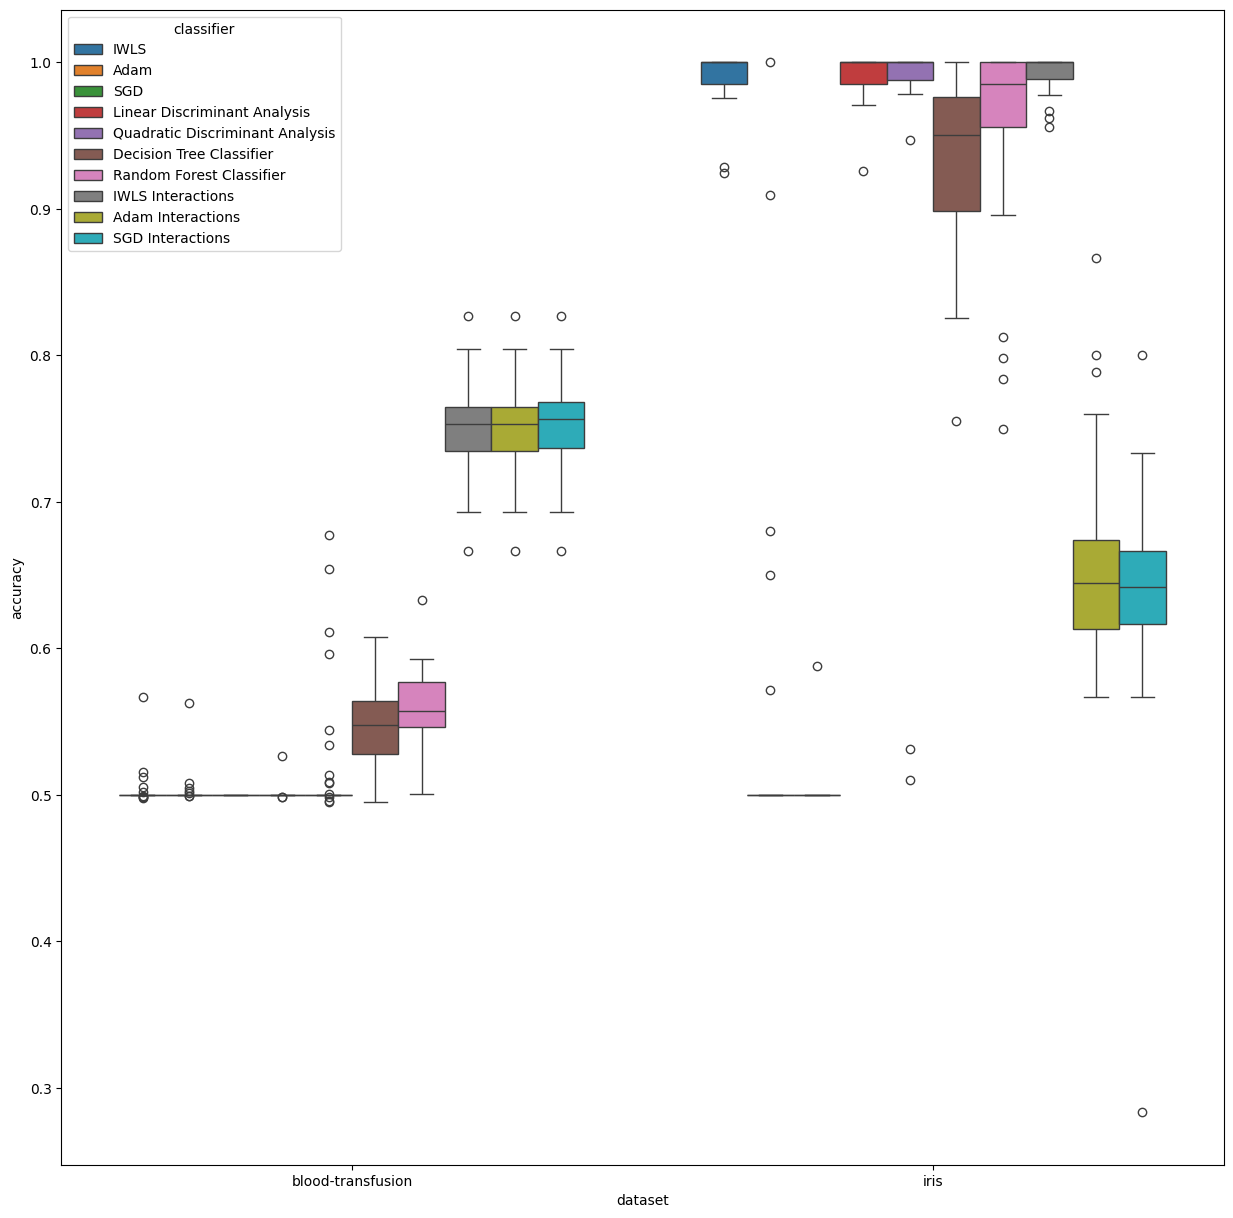

In [15]:
accuraciesDf = pd.DataFrame(accuracies[0],columns=['accuracy','classifier','seed','split','interactions','dataset'])
accuraciesDf=accuraciesDf.apply(lambda x:mapOptimizerToString(x),axis=1)
concatAcc=accuraciesDf
for i in range(1,len(accuracies)):
    accuraciesDf = pd.DataFrame(accuracies[i],columns=['accuracy','classifier','seed','split','interactions','dataset'])
    accuraciesDf=accuraciesDf.apply(lambda x:mapOptimizerToString(x),axis=1)
    concatAcc=pd.concat([concatAcc, accuraciesDf], ignore_index=True, sort=False)
plt.figure(figsize=(15,15))
sns.boxplot(concatAcc,x='dataset',y='accuracy',hue='classifier')
plt.show()

## Accuracies per split

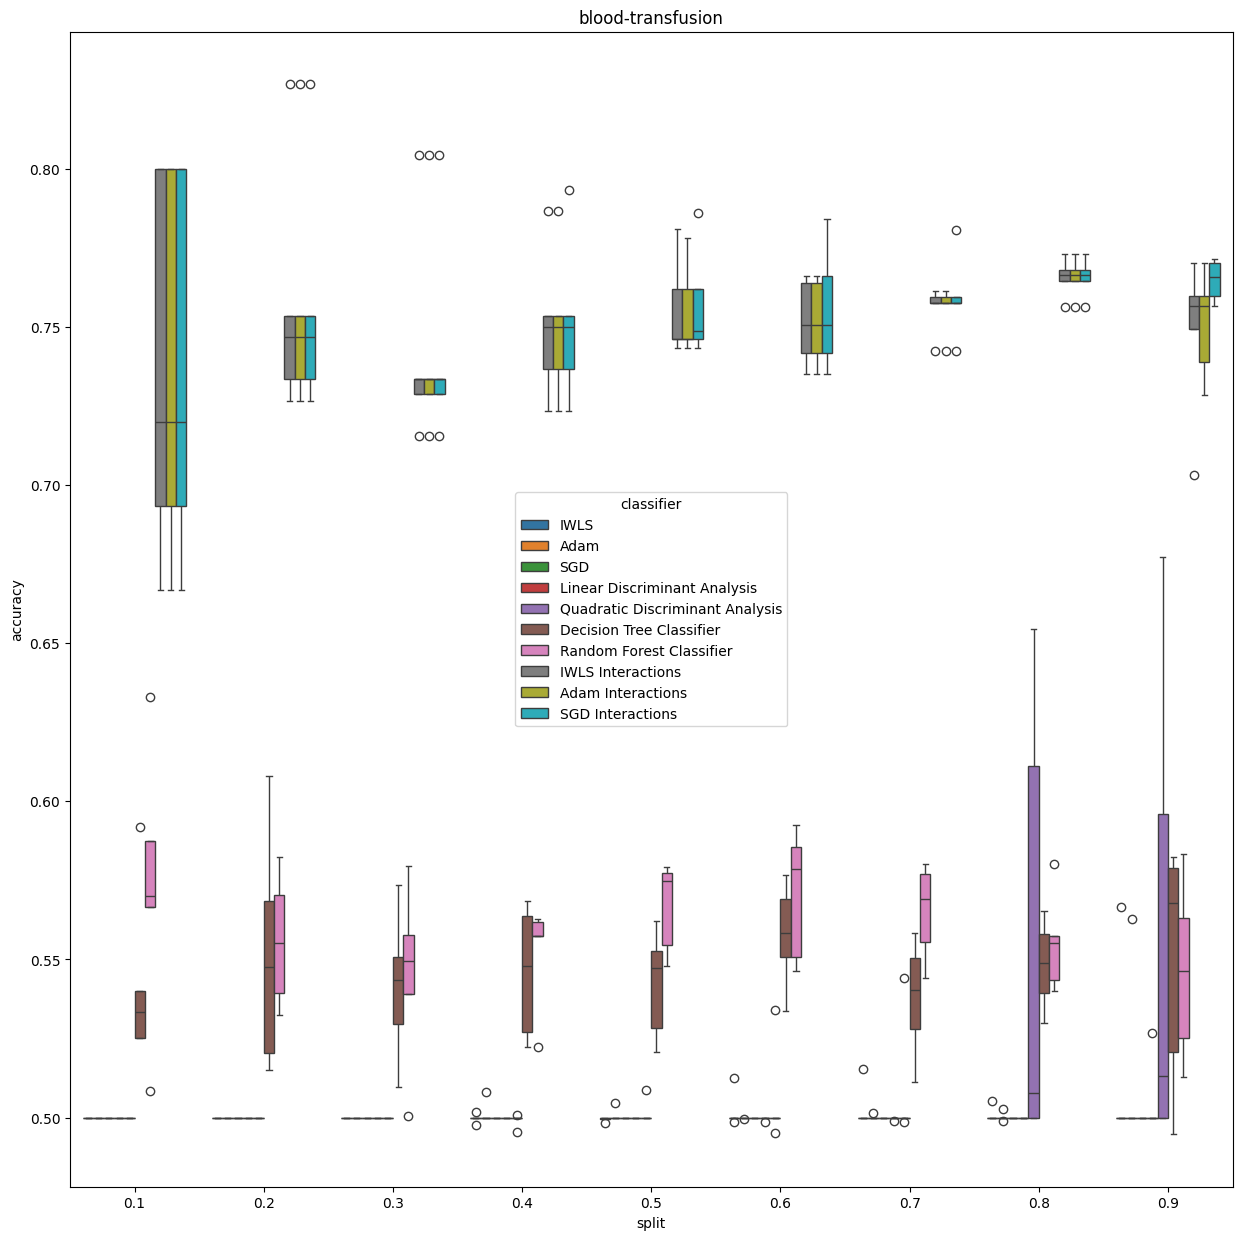

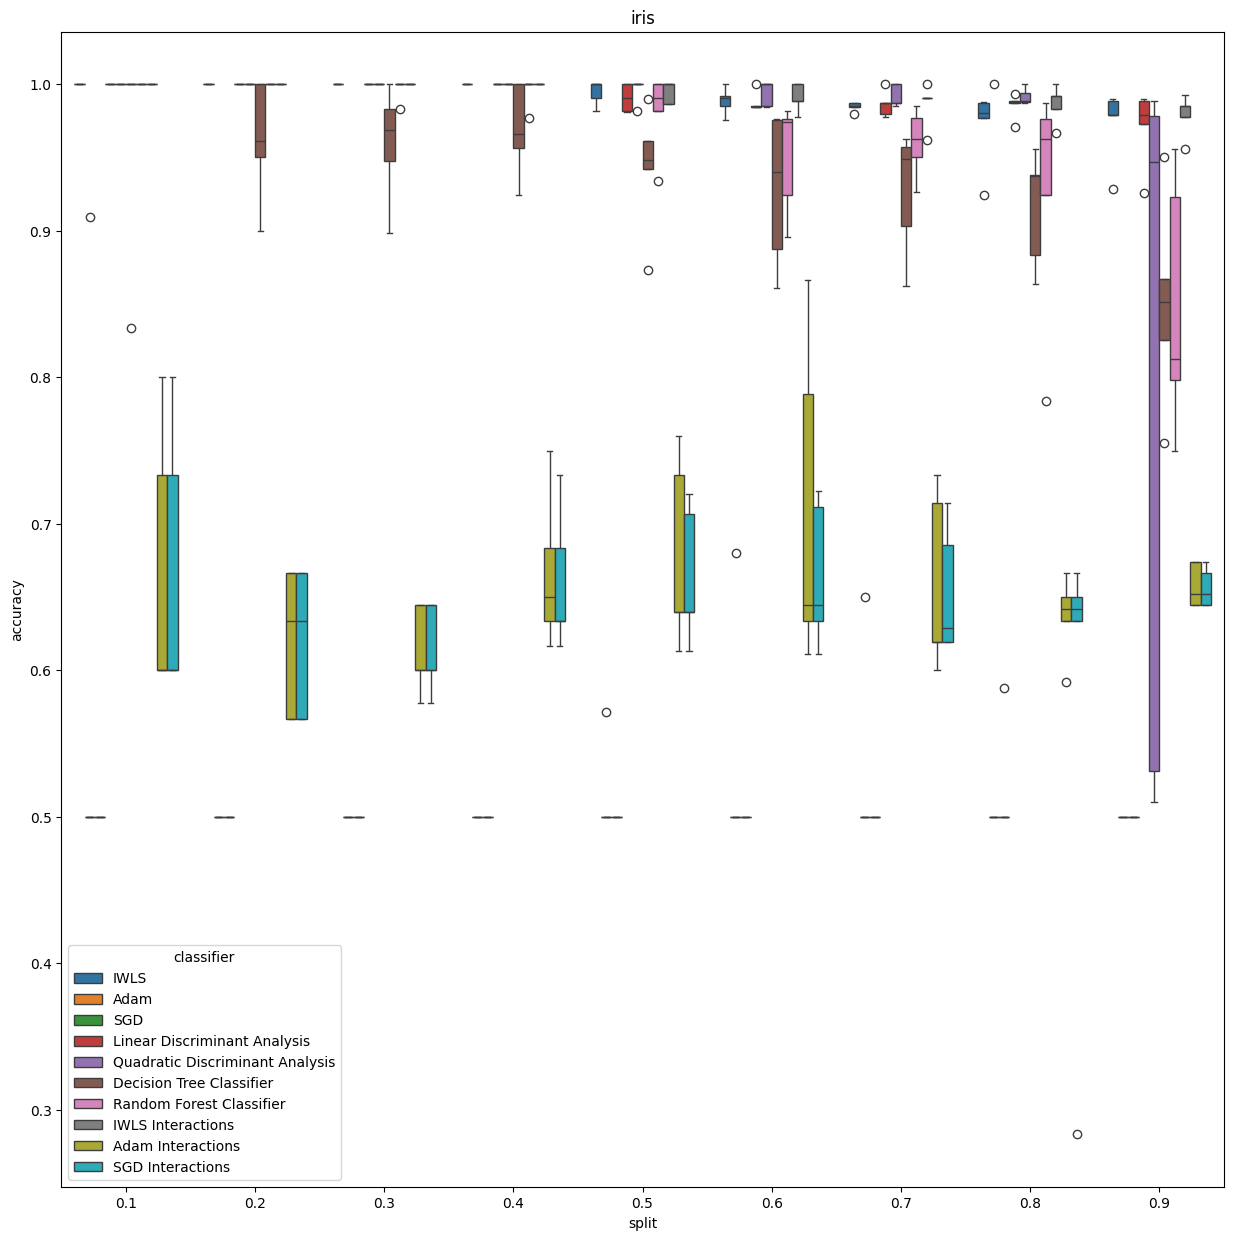

In [16]:
for accuracy in accuracies:
    accuraciesDf = pd.DataFrame(accuracy,columns=['accuracy','classifier','seed','split','interactions','dataset'])
    accuraciesDf=accuraciesDf.apply(lambda x:mapOptimizerToString(x),axis=1)

    
    plt.figure(figsize=(15,15))
    plt.title(accuraciesDf['dataset'][0])
    sns.boxplot(accuraciesDf,x='split',y='accuracy',hue='classifier')
    plt.show()

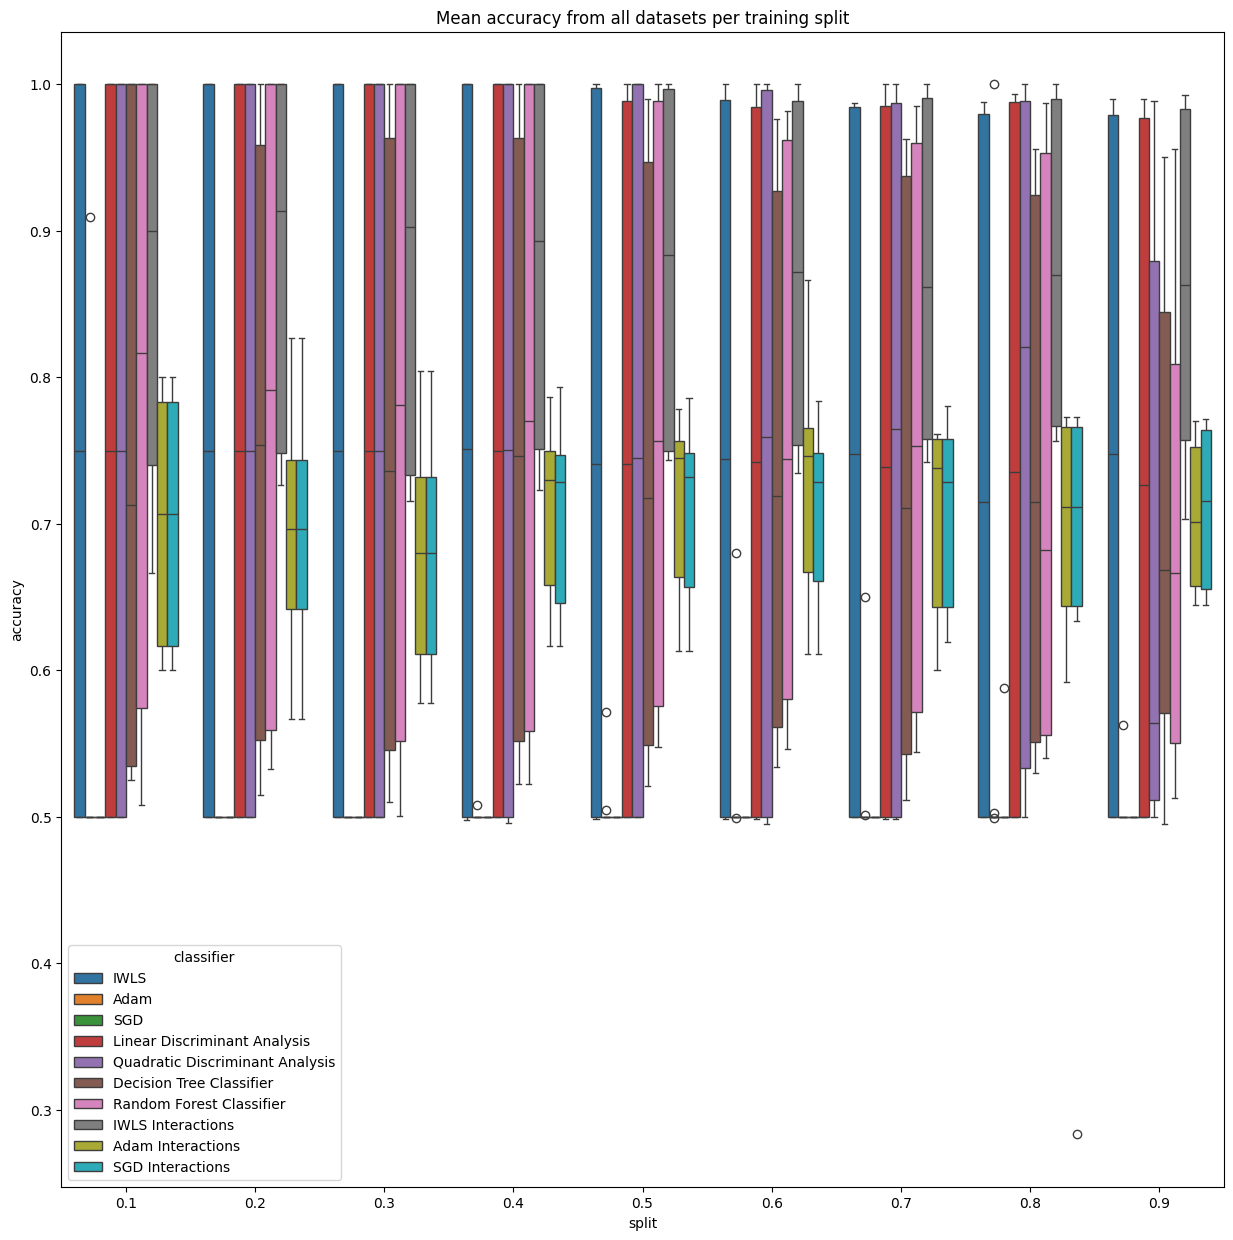

In [17]:

accuraciesDf = pd.DataFrame(accuracies[0],columns=['accuracy','classifier','seed','split','interactions','dataset'])
accuraciesDf=accuraciesDf.apply(lambda x:mapOptimizerToString(x),axis=1)

# meanacc = getMeanAccuracyPerSplit(accuraciesDf)
concatAcc = accuraciesDf
for i in range(1,len(accuracies)):
    accuraciesDf = pd.DataFrame(accuracies[i],columns=['accuracy','classifier','seed','split','interactions','dataset'])
    accuraciesDf=accuraciesDf.apply(lambda x:mapOptimizerToString(x),axis=1)
    # meanacc = getMeanAccuracy(accuraciesDf)
    concatAcc=pd.concat([concatAcc, accuraciesDf], ignore_index=True, sort=False)


plt.figure(figsize=(15,15))
plt.title('Mean accuracy from all datasets per training split')
sns.boxplot(concatAcc,x='split',y='accuracy',hue='classifier')
plt.show()

# Loss function

C:\Users\prusak.patryk\AppData\Local\Temp\ipykernel_29420\3318265352.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  costsDf=pd.concat([costsDf, costDf], ignore_index=True, sort=False)


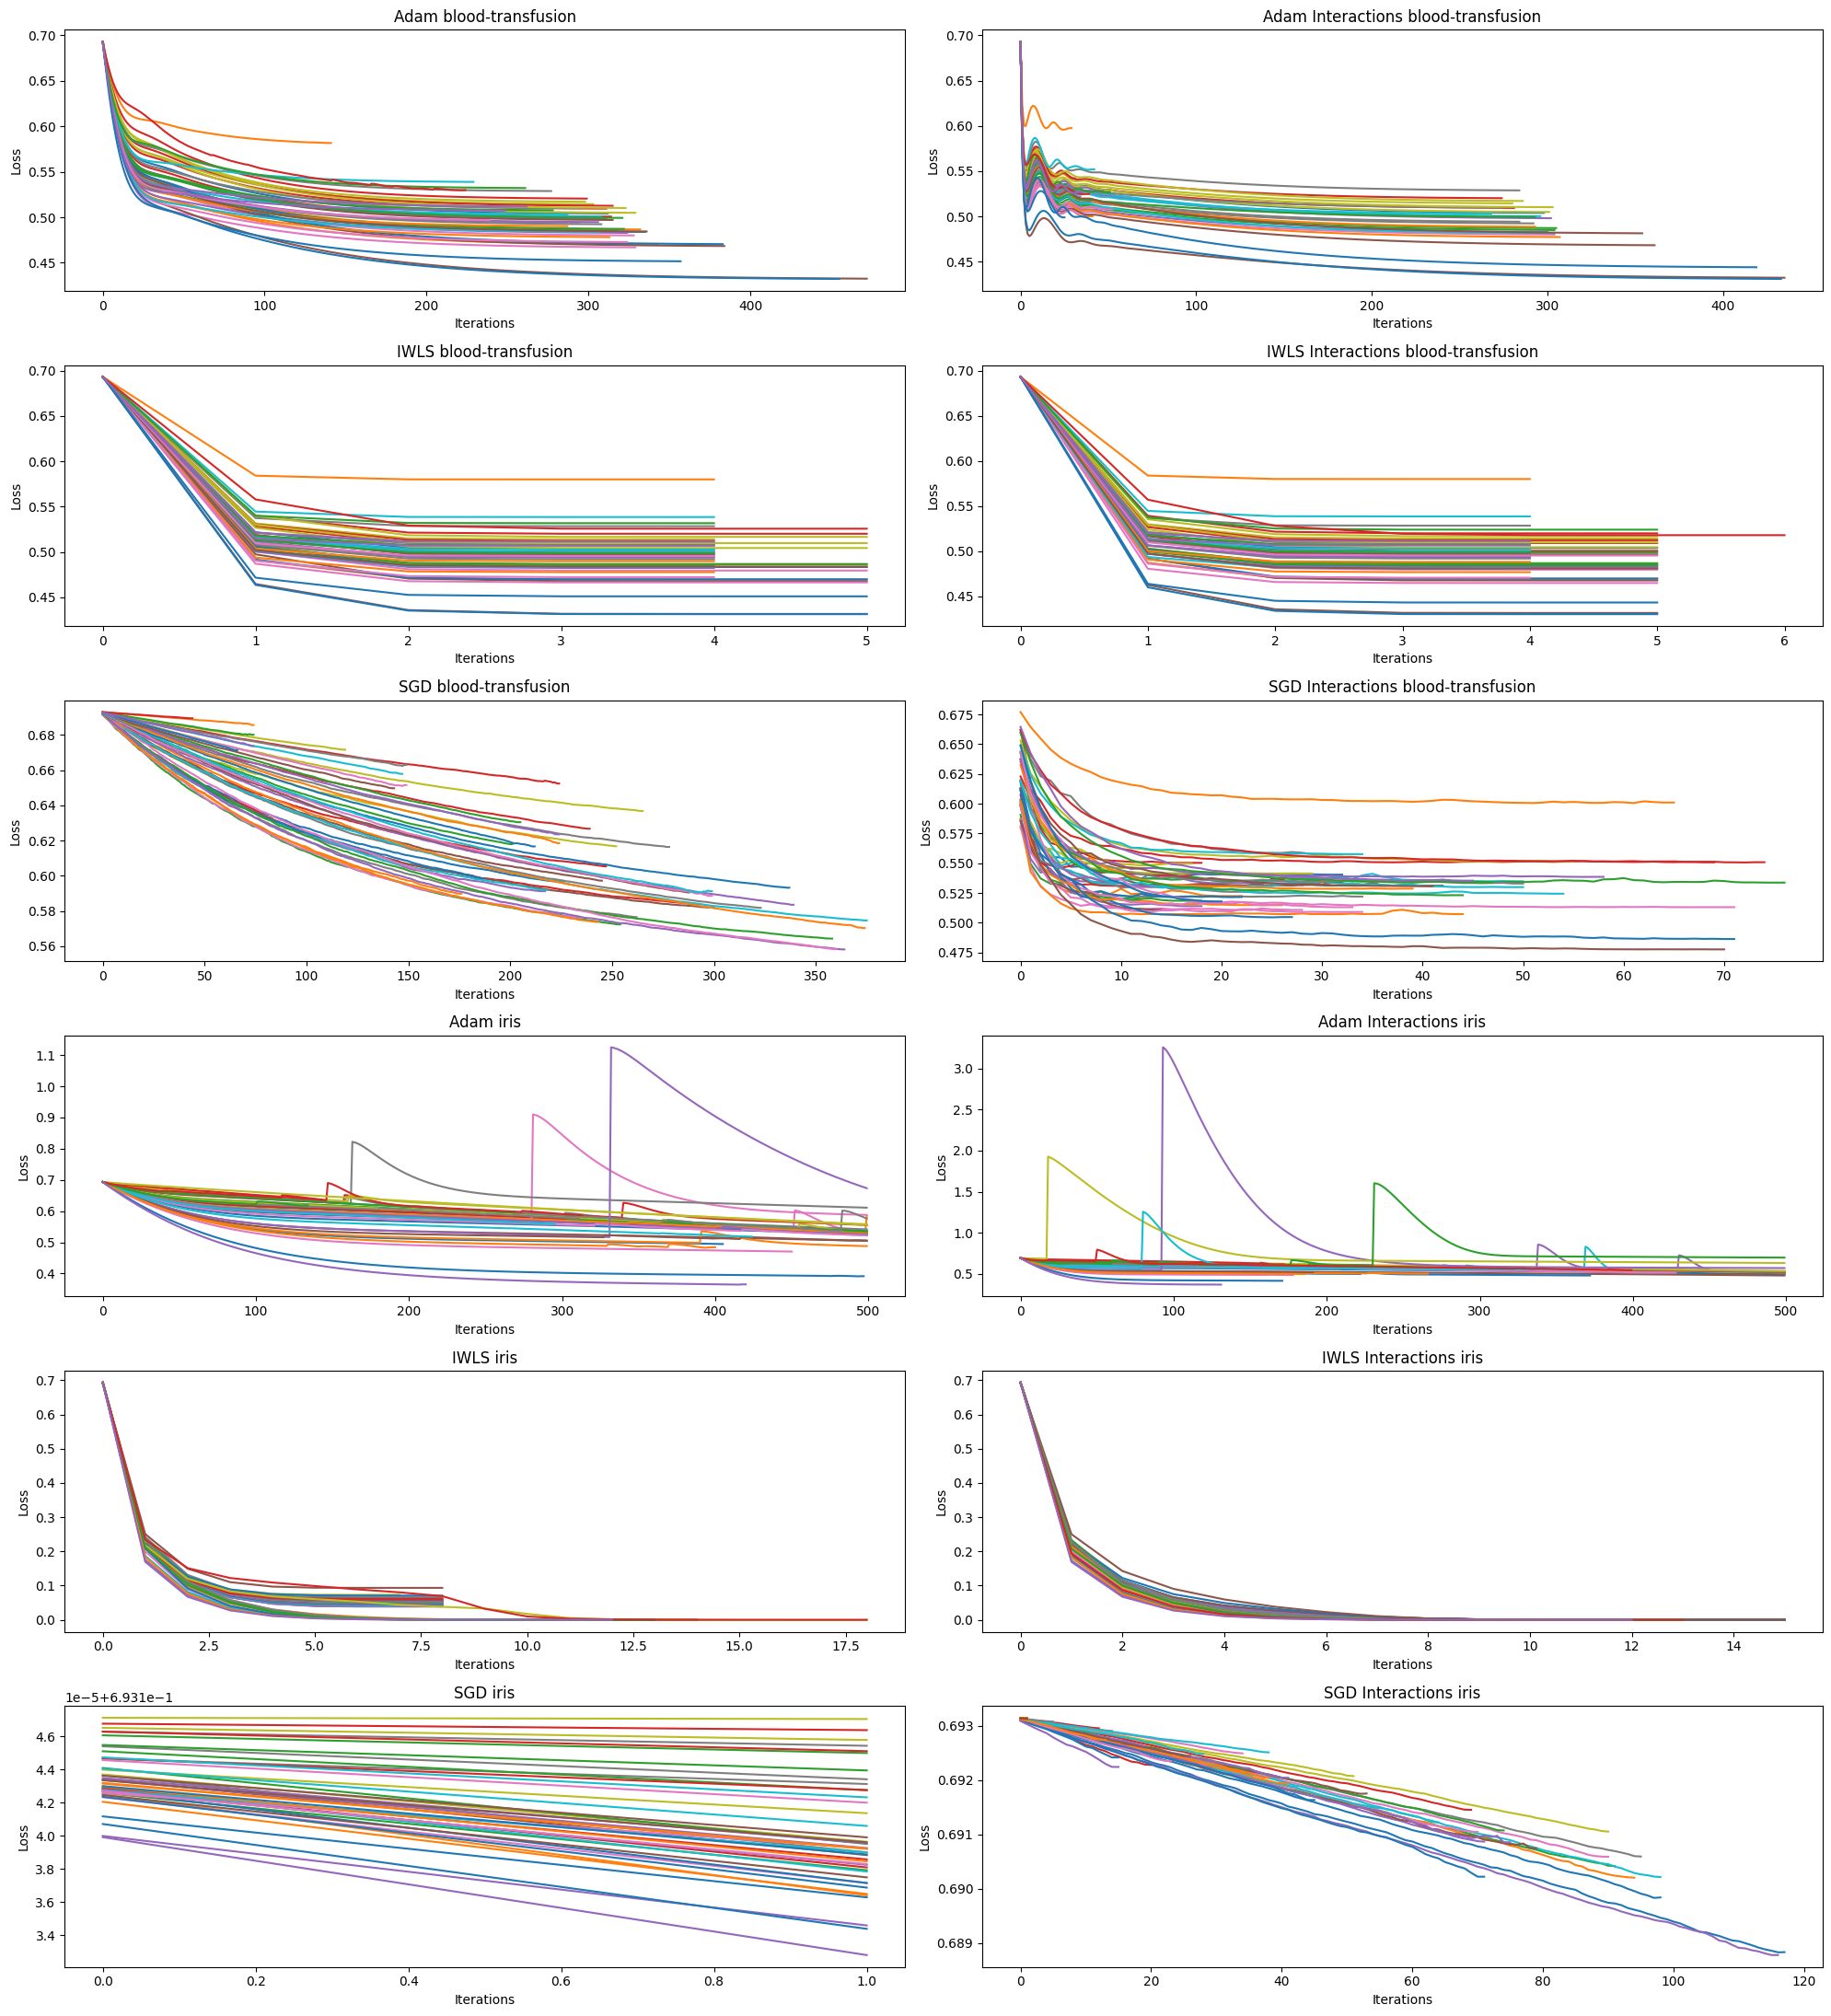

In [116]:
# Need to group the results, and then calculate the mean column wise
costsDf = pd.DataFrame(columns=['cost','classifier','seed','split','interactions','dataset'])
for cost in costs:
    costDf = pd.DataFrame(columns = ['cost','classifier','seed','split','interactions','dataset'],data=cost)
    costsDf=pd.concat([costsDf, costDf], ignore_index=True, sort=False)
costsDf=costsDf.apply(lambda x:mapOptimizerToString(x),axis=1)
grouped =costsDf.groupby(by=['dataset','classifier'])

costFunctionToPlot = []
for name, group in grouped:
    # means = group['cost'].values.mean(axis=0)
    costFunctionToPlot.append([group['cost'],group['classifier'].iloc[0],group['dataset'].iloc[0]])

i =0 
totalNumberOfGraphs = len(costFunctionToPlot)
numberOfColumns = 2
numberOfRows = totalNumberOfGraphs // numberOfColumns 
if totalNumberOfGraphs % numberOfColumns != 0:
    numberOfRows += 1

positionsVector = range(1,totalNumberOfGraphs + 1)
fig = plt.figure(1,figsize=(20,22))
#fig.tight_layout()
for algorithmCosts in costFunctionToPlot:
    ax = fig.add_subplot(numberOfRows,numberOfColumns,positionsVector[i])
    ax.title.set_text(algorithmCosts[1]+" "+ algorithmCosts[2])
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    for costsToPlot in algorithmCosts[0]:
        sns.lineplot(costsToPlot, ax=ax)
    i+=1
plt.tight_layout()
plt.show()